In [1]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    #BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
from cca_zoo.model_selection import GridSearchCV
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.stats import fisher_exact
from scipy.stats.contingency import crosstab
from scipy.stats import hypergeom
import random
import pandas as pd
import numpy as np
import pickle
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import seed_everything
from torch import nn

os.chdir('../raw_data')


#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [3]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()[:1000] #just a subset for scripting
df_all.shape

(1000, 8)

In [4]:
class DeepCCA:
    def __init__(self, df_all,batch_size = 768,num_workers = 6,\
                latent_dims=100, epochs=300, lr=0.001): #default dims determined after iteratin 10:50 dims 
        
        self.df_all = df_all
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.v1='ms2ds'
        self.v2 = 'mol2vec'
        
        self.epochs = epochs
        self.sdl_lr = 0.025118864315095822#0.01#lr (picked after running lr_finder) auto lr enabled
        self.dcca_lr = 5.623413251903491e-08 #lr
        self.latent_dims=latent_dims
        self.optim = 'sgd'
        self.activation = nn.Tanh()
        self.objective = objectives.CCA
        self.encoder_1_layers = (500,500)
        self.encoder_2_layers = (500,500)
        #seed_everything(15) # seeding is not decide to test model reproducibility
        
        
    def split_data(self,test_size=0.2,\
                   random_state=None,stratify=None): # thinking of removing this one
        
        if random_state != None and stratify == None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=random_state)
        
        elif random_state == None and stratify != None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size,stratify=self.df_all[stratify])
        else:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=42)
        
        return train_df, test_df 
    
    def gen_views(self,v1='ms2ds',v2='mol2vec'):
        
        #split test, train
        train_df, test_df= self.split_data(test_size=0.2,random_state=42)
        
        #Split train dataset into train and validation set
        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
        
        
        #extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
        v1_train, v1_test = np.array([x for x in train_df[v1]]), np.array([x for x in test_df[v1]])
        v2_train, v2_test = np.array([x for x in train_df[v2]]), np.array([x for x in test_df[v2]])

        # validation
        v1_val, v2_val = np.array([x for x in val_df[v1]]), np.array([x for x in val_df[v2]])
        
        #update self dfs
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        
        # not memory efficient !!!
        self.v1_train, self.v1_test = v1_train, v1_test
        self.v2_train, self.v2_test = v2_train, v2_test
        self.v1_val, self.v2_val = v1_val, v2_val
        
        return None
    
    def deepcca_encoders(self):
        # define encoders
        self.encoder_1 = architectures.Encoder(
                                      latent_dims = self.latent_dims, 
                                      feature_size = self.v1_size,
                                      layer_sizes = self.encoder_1_layers,
                                      activation = self.activation
                                    )
                                     
        self.encoder_2 = architectures.Encoder(
                                      latent_dims=self.latent_dims, 
                                      feature_size=self.v2_size, 
                                      layer_sizes=self.encoder_2_layers,
                                      activation = self.activation
                                     )
       
        return None#[encoder_1, encoder_2]
        
    
    def deepcca_dataloaders(self):
        
        #v1_train,v1_test, v2_train,v2_test, v1_val, v2_val = \
        self.gen_views(v1=self.v1, v2=self.v2)
        
        #creat CCA dataset 
        train_dataset = CCA_Dataset([self.v1_train, self.v2_train])
        test_dataset = CCA_Dataset([self.v1_test, self.v2_test])
        val_dataset = CCA_Dataset([self.v1_val, self.v2_val])
        
        #update features size
        self.v1_size = self.v1_train.shape[1]
        self.v2_size = self.v2_train.shape[1]
        self.N = len(train_dataset)
        
        #set N (for sdl; equal len train dataset)
        self.N = len(train_dataset)
        
        #loaders
        self.train_loader , self.val_loader = get_dataloaders(train_dataset, \
                                                    val_dataset,batch_size=self.batch_size,\
                                                    num_workers=self.num_workers,drop_last=False)
        self.test_loader = get_dataloaders(test_dataset,\
                                      batch_size=self.batch_size, \
                                      num_workers=self.num_workers,drop_last=False)
        
        
        
        
        return None
    
    
    def train_cca(self): #only for comparison with other deep models
        
       
        
        #define and train cca model
        print('\n','-'*20,'\n Training CCA\n','-'*20)
        cca = CCA(latent_dims=self.latent_dims).fit((self.v1_train, self.v2_train))
        self.cca = cca
        return None#cca
    
    def train_sdl(self, checkpoint=None, logger=None,lam=0.0001,enable_progress_bar=True ):
        
        
        # 2. SDL
        sdl = DCCA_SDL(self.latent_dims,
                       optimizer=self.optim,
                       N=self.N, 
                       encoders = [self.encoder_1,self.encoder_2],
                       lam=0.0001, 
                       lr=self.sdl_lr,
                       dropout=0.05,
                       objective=self.objective) 

        
        
        #define the trainer
        
        self.trainer = pl.Trainer(#default_root_dir=default_root_dir,
                             logger = logger,
                             max_epochs=self.epochs, #enable early stoppage instead of specifiying num epochs                           
                             log_every_n_steps=1,
                             val_check_interval = 1, #`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
                             
                             callbacks=[
                                checkpoint,
                                 #pl.callbacks.early_stopping.EarlyStopping(monitor="val/l2") # early stopage to reduce overfitting
                             ],
                            enable_progress_bar=enable_progress_bar,
                            auto_lr_find = True
                                )#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting
        
        print('\n','-'*20,'\n Training SDL\n','-'*20)
        self.trainer.fit(sdl, self.train_loader,self.val_loader)
        self.sdl = sdl
        return None#sdl
    
    def train_dcca(self):
        
       
        
        # 2. DCCA
        dcca = DCCA(self.latent_dims,
                    optimizer=self.optim,
                    encoders = [self.encoder_1,self.encoder_2],
                    lr=self.dcca_lr,
                    objective=self.objective) 

        #train
        #tb_logger = pl_loggers.TensorBoardLogger(save_dir="pl_logs/dcca")
        trainer = pl.Trainer(default_root_dir="./dcca",max_epochs=self.epochs,log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

        print('\n','-'*20,'\n Training DCCA\n','-'*20)
        trainer.fit(dcca, self.train_loader,self.val_loader)
        
        self.dcca = dcca
        
        return None #dcca
    
    
    
    def score(self,model,dataset): 
        """
        model: either 'cca', 'dcca', 'sdl'
        dataset: 'train', 'test', or 'val'
        
        returns: correlation 
        """
       # for cca models 
        #m = eval(model)
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        if model == 'cca':
            corr = self.cca.score([v1,v2])
        
        if model == 'sdl':
            corr = self.sdl.score(loader)
        
        elif model == 'dcca':
            corr = self.dcca.score(loader)
       
        return corr
    def update_z_scores(self,dataset, z1,z2,cols):
        #update train df with transformed z scores
            if dataset == 'train':
                
                self.train_df[cols[0]] = [x for x in z1]
                self.train_df[cols[1]] = [x for x in z2]
                
            #update test df
            if dataset == 'test':
                self.test_df[cols[0]] = [x for x in z1]
                self.test_df[cols[1]] = [x for x in z2]
            
            #update val df
            if dataset == 'val':
                self.val_df[cols[0]] = [x for x in z1]
                self.val_df[cols[1]] = [x for x in z2]
            return None
                
        
    
    def transform(self,model,dataset):
        """
        model: either 'cca', 'dcca', 'sdl': of course the model must have been fitted :)
        loader: is similar data loader used to train either sdl/dcca
        dataset: either 'train', 'test', 'val'
        
        returns transformed data; view1,view2
        """
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        
        #specify the model for transformation
        if model == 'cca':
            z1,z2 = self.cca.transform([v1,v2]) #transform
            self.update_z_scores(dataset,z1,z2,cols=['cca_z1','cca_z2']) # update the df with z scores            
    
            
        if model == 'sdl':
            z1,z2 = self.sdl.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['sdl_z1','sdl_z2'])
                
        
        if model == 'dcca':
            z1,z2 = self.dcca.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['dcca_z1','dcca_z2'])
        
        
        return None##z1,z2; can be found in self.<df[model_z]>       
        

<h1> Train the final Model with optimised parameters<h1>

In [13]:
%%time
# Initiate the DeepCCA oject
Models = DeepCCA(df_all)

# generate data loaders and cca v1,v2
Models.deepcca_dataloaders()

    # set up the encoders
Models.deepcca_encoders()
    
    # train cca
Models.train_cca() 

#set up logger for deepcca
version =  'final_model'
   
experiment_dir = './sdl_logs'
    
model_checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')
    
logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='sdl_optimized_params',
                                   version = version)
        # train sdl
Models.train_sdl(model_checkpoint, logger,enable_progress_bar=True) 

#calculate the correlations

#cca

    #train correlation
cca_train_corr  = Models.score(model='cca', dataset='train')

    #test correlation
cca_test_corr  = Models.score(model='cca', dataset='test')


#DeepCCA

    #train correlation
    
deepcca_train_corr  = Models.score(model='sdl', dataset='train')

    #test correlation
deepcca_test_corr  = Models.score(model='sdl', dataset='test')


# Transform the dataset. (calculate the z scores)

#cca
Models.transform(model='cca', dataset='train')
Models.transform(model='cca', dataset='test')
Models.transform(model='cca', dataset='val')

#deepcca
Models.transform(model='sdl', dataset='train')
Models.transform(model='sdl', dataset='test')
Models.transform(model='sdl', dataset='val')


#write the transformed df to file for the 
dfs = [Models.train_df, Models.test_df, Models.val_df]
paths = ['./sdl_logs/sdl_optimized_params/train_df_max3_sdl_and_cca_final_model_z_scores.pickle',
         './sdl_logs/sdl_optimized_params/test_df_max3_sdl_and_cca_final_model_z_scores.pickle',
         './sdl_logs/sdl_optimized_params/val_df_max3_sdl_and_cca_final_model_z_scores.pickle'
        ]
for path, df in zip(paths,dfs):
    Files(path).write_to_file(df)
    
# write correlations to file

correlations_df = pd.DataFrame({'latent_dimensions': [x+1 for x in range(Models.latent_dims)],
                                'cca_train_corr': cca_train_corr,
                                'cca_test_corr': cca_test_corr,
                                'deepcca_train_corr': deepcca_train_corr,
                                'deepcca_test_corr': deepcca_test_corr})

Files('./sdl_logs/sdl_optimized_params/final_model_cca_and_sdl_max3_correlation_df.pickle').write_to_file(correlations_df)

In [14]:
correlations_df.head()

,latent_dimensions,cca_train_corr,cca_test_corr,deepcca_train_corr,deepcca_test_corr
0,1,0.985337,0.695807,0.989719,0.999997
1,2,0.980327,0.415773,0.960048,0.999996
2,3,0.978053,0.432494,0.914835,0.999803
3,4,0.976693,0.403096,0.909627,0.999733
4,5,0.975939,0.355498,0.841738,0.999506


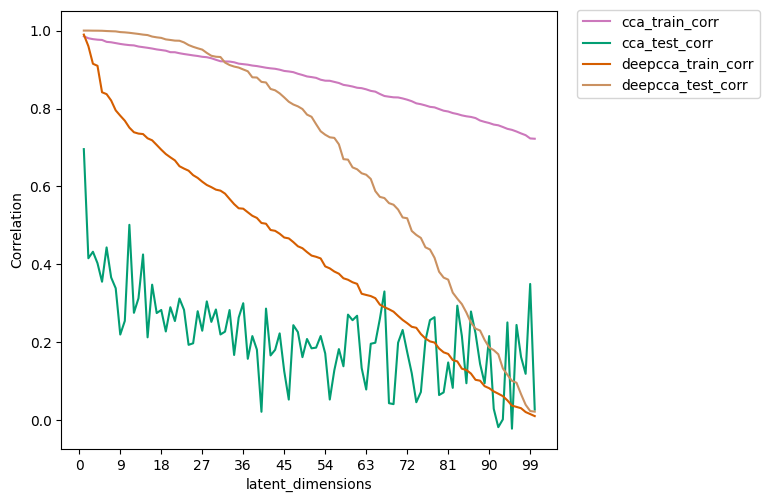

In [30]:

# df_long = correlations_df.melt('latent_dimensions', var_name='Model', value_name='Correlation')


# palette = [sns.color_palette("colorblind")[4],\
#            sns.color_palette("colorblind")[2],\
#            sns.color_palette("colorblind")[3],
#           sns.color_palette("colorblind")[5]]

# plt.figure(figsize=(6.4, 5.8),dpi=100)
# sns.lineplot(x="latent_dimensions", y="Correlation", 
#             hue='Model', data=df_long, palette=palette)
# plt.xticks(np.arange(0, 100, step=9))
# plt.legend(loc=(1.04, 0.8))
# plt.show()

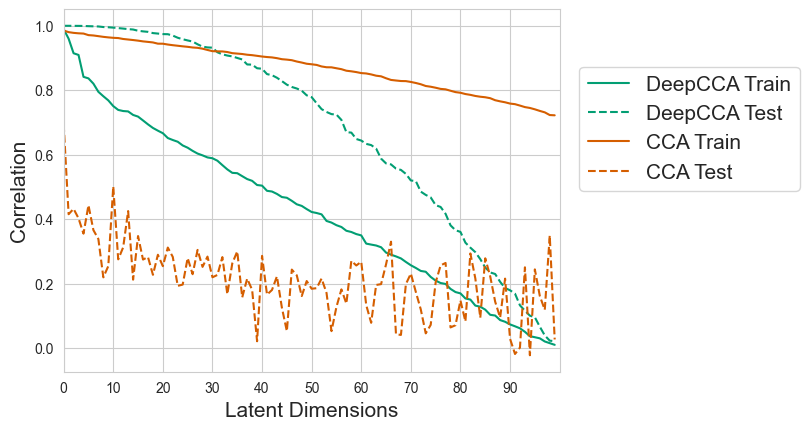

<Figure size 640x580 with 0 Axes>

In [41]:


x=[x for x in range(Models.latent_dims)]


sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [#sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]]

dfs = [#[dcca_train_corr, dcca_test_corr],\
       [deepcca_train_corr, deepcca_test_corr],\
       [cca_train_corr,cca_test_corr]]
fig, ax = plt.subplots(figsize=(6.4, 4.8),dpi=100)
for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=x,y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=[#'DCCA Train', 'DCCA Test',\
                      'DeepCCA Train', 'DeepCCA Test',\
                      'CCA Train', 'CCA Test'], \
                       loc=(1.04, 0.5),\
                    fontsize=15)#title='Algorithm', 
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
#plt.ylim(0, 1)
#plt.title(label=f'DeepCCA vs CCA; \n pairwise Correlation between spectrum & structure\n',\
          #fontsize=14,loc='center')
plt.xlim(0, 100)
plt.xticks(np.arange(0, 100, step=10))
#plt.yticks(np.arange(0, 1.01, step=0.1))
plt.savefig('./sdl_logs/sdl_optimized_params/final_model_cca_and_sdl_max3_correlation_plot.png',\
           transparent=False,bbox_inches = 'tight')
plt.figure(figsize=(6.4, 5.8),dpi=100)
plt.show()